# Here we are going to run some simulations for Red Thread matchmaking!!
If all goes well I may even come up with some innovative formulas :3

## First we gotta setup some python stuff
Run the following commands to get python setup correctly

In [17]:
!pip3 install numpy matplotlib geopandas contextily rtree geodatasets

  Obtaining dependency information for geodatasets from https://files.pythonhosted.org/packages/d4/b0/dccab6d4dc86d832b5503d261d4bdceb2331fd4f0abe4726b8f44e7d61a4/geodatasets-2023.12.0-py3-none-any.whl.metadata
  Obtaining dependency information for pooch from https://files.pythonhosted.org/packages/a8/87/77cc11c7a9ea9fd05503def69e3d18605852cd0d4b0d3b8f15bbeb3ef1d1/pooch-1.8.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 3.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


### Now that we have installed these libraries let's go ahead and import them. we will be using them a lot!!

In [9]:
import numpy as np
import matplotlib.pyplot as plt

## Key considerations
The following probability distributions will be key to matchmaking

### User age

First let's define some key parameters. When we get real data we can extract these key paramters from real data!!!! For now we have to be creative

In [10]:
# Parameters for the normal distribution
mean_age = 30  # Average age
std_dev_age = 5  # Standard deviation
num_of_users = 10000  # Number of users

Let's use these parameters to generate some data. We also need to impose the requirement that all users be at least 18 years old.

In [11]:
# Generate a large amount of data to ensure we have enough valid ages
initial_sample_size = num_of_users * 2  # Generate twice the required number of users
age_data = np.random.normal(mean_age, std_dev_age, initial_sample_size)

# Filter out ages below 18
age_data = age_data[age_data >= 18]

# If we have more than enough valid ages, we take only the first num_of_users
if len(age_data) > num_of_users:
    age_data = age_data[:num_of_users]
else:
    # If not enough, we generate more data until we have enough valid ages
    while len(age_data) < num_of_users:
        additional_data = np.random.normal(mean_age, std_dev_age, num_of_users)
        additional_data = additional_data[additional_data >= 18]
        age_data = np.concatenate((age_data, additional_data))

        # Keep only the required number of users
        if len(age_data) > num_of_users:
            age_data = age_data[:num_of_users]

Now that we have a good dataset let's plot it

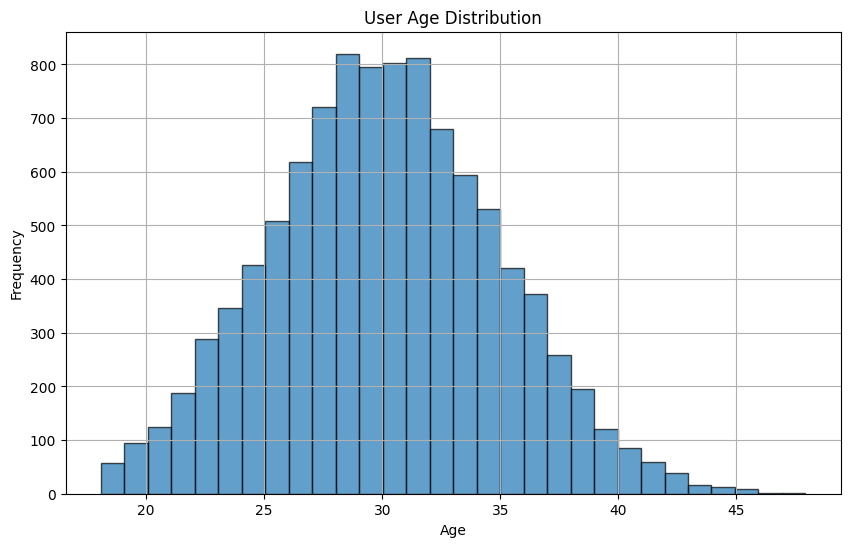

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(age_data, bins=30, edgecolor='black', alpha=0.7)
plt.title('User Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Gender Distribution

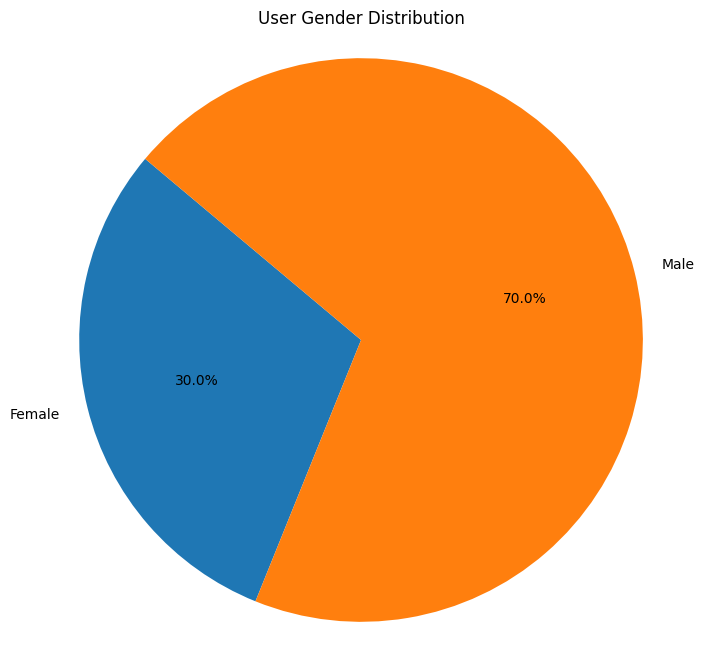

In [13]:
# Gender Distribution
gender_distribution = [0.7, 0.3]  # 70% male, 30% female

# Generate gender data
genders = np.random.choice(['Male', 'Female'], size=num_of_users, p=gender_distribution)

# Count occurrences of each gender
unique, counts = np.unique(genders, return_counts=True)
gender_counts = dict(zip(unique, counts))

# Plotting the gender distribution
plt.figure(figsize=(8, 8))
plt.pie(gender_counts.values(), labels=gender_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('User Gender Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## User Location

This is where it gets hard. Let's assume that everyone is in NYC for now

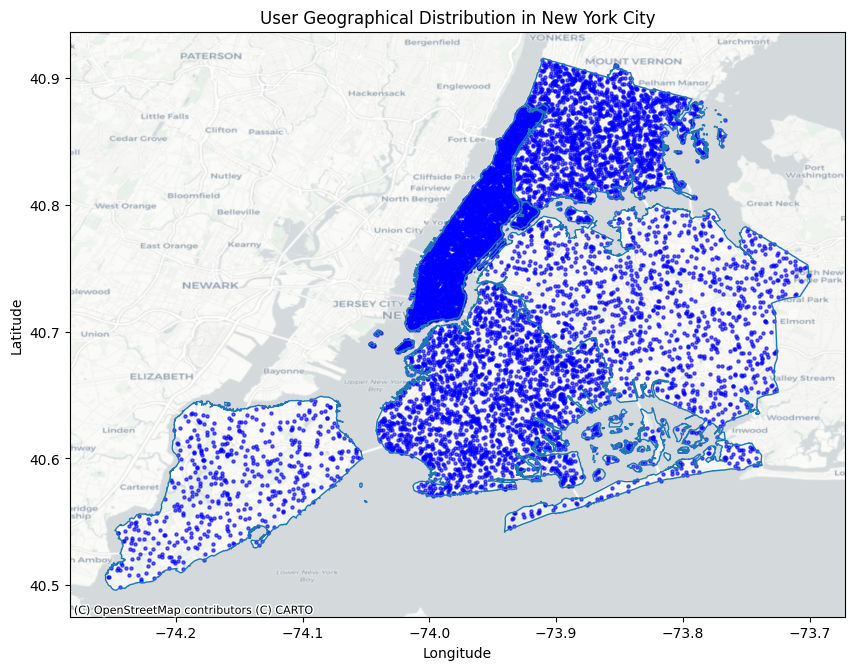

In [20]:
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
from rtree import index
from geodatasets import get_path

# Load the built-in NYC borough boundaries dataset
nyc_land = gpd.read_file(get_path('nybb'))
nyc_land = nyc_land.to_crs(epsg=4326)  # Ensure it is in WGS84 coordinate system

# Population densities for NYC boroughs (in people per square mile)
# Source: Approximate data from various sources
population_densities = {
    'Manhattan': 72000,
    'Bronx': 33000,
    'Brooklyn': 38000,
    'Queens': 21000,
    'Staten Island': 8300
}

# Assign probabilities based on relative population densities
total_density = sum(population_densities.values())
borough_probs = {k: v / total_density for k, v in population_densities.items()}

# Parameters
num_of_users = 1000

# Function to generate random points within a borough
def generate_random_points_within_borough(polygon, num_points):
    points = []
    minx, miny, maxx, maxy = polygon.bounds

    while len(points) < num_points:
        random_points = [Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy)) for _ in range(num_points)]
        for point in random_points:
            if polygon.contains(point):
                points.append(point)
                if len(points) >= num_points:
                    break
    return points

# Generate random points for each borough according to their population density probabilities
random_points = []
for borough, prob in borough_probs.items():
    borough_polygon = nyc_land[nyc_land['BoroName'] == borough].geometry.unary_union
    num_points = int(prob * num_of_users)
    random_points.extend(generate_random_points_within_borough(borough_polygon, num_points))

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame({'geometry': random_points})
gdf.crs = 'EPSG:4326'

# Plotting the user locations
fig, ax = plt.subplots(figsize=(10, 10))
nyc_land.boundary.plot(ax=ax, linewidth=1)
gdf.plot(ax=ax, markersize=5, color='blue', alpha=0.6)
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)
plt.title('User Geographical Distribution in New York City')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
